In [1]:
import glob
import os
import librosa
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
def extract_features(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.array(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=8).T)
    chroma = np.array(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T)
    mel = np.array(librosa.feature.melspectrogram(X, sr=sample_rate).T)
    contrast = np.array(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T)
    tonnetz = np.array(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T)
    return mfccs,chroma,mel,contrast,tonnetz

In [3]:
def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    ignored = 0
    features, labels, name = np.empty((0,161)), np.empty(0), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        print(sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_features(fn)
                ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
                features = np.vstack([features,ext_features])
                l = [fn.split('-')[1]] * (mfccs.shape[0])
                labels = np.append(labels, l)
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                ignored += 1
    print ("Ignored files: ", ignored)
    return np.array(features), np.array(labels, dtype = np.int)

## load sounds and extract features and labels

In [4]:
parent_dir = 'C:/Users/rano4/Desktop/5thyear/graduationproject/Project/UrbanSound8K/audio'

#sub_dirs = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']
sub_dirs = ['fold1']

try:
    labels = np.load('labels.npy')
    features = np.load('features.npy')
    print("Features and labels found!")
except:
    print("Extracting features...")
    features, labels = parse_audio_files(parent_dir,sub_dirs)
    with open('features.npy', 'wb') as f1:
            np.save(f1,features)
    with open('labels.npy', 'wb') as f2:
            np.save(f2, labels)

Features and labels found!


In [5]:
print("Splitting Data!")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)

Splitting Data!


## normalization data

In [6]:
print("normalization data")
sc = StandardScaler()
sc.fit(X_train)

normalization data


StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
with open("fit_params.npy", "wb") as f3:
    np.save(f3, X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## fitting and Training data

In [8]:
print("fitting and Training data")
clf = MLPClassifier()
clf.fit(X_train, y_train)

fitting and Training data


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Score

In [9]:
print('score (training): {:.3f}'
     .format(clf.score(X_train, y_train)))
print('score (test): {:.3f}'
     .format(clf.score(X_test, y_test)))
print("show out parameter")
print('linear model intercept: {}'
     .format(clf.intercepts_ ))
print('linear model coeff:\n{}'
     .format(clf.coefs_ ))

score (training): 0.845
score (test): 0.839
show out parameter
linear model intercept: [array([ -1.07927378e+00,  -7.20436608e-01,   2.90849380e-01,
         1.26147760e+00,   3.75892444e-01,  -1.24420214e-01,
        -4.32517214e-01,  -1.20737453e+00,   1.25157699e-01,
        -1.45353397e+00,  -2.46263070e+00,  -5.42305890e-01,
        -3.73774280e+00,   1.04491223e+00,  -2.49758444e-01,
        -8.77850379e-01,  -3.20417079e-01,  -1.97502914e+00,
         2.57570641e-01,   7.04947232e-02,  -3.78661404e-01,
        -1.24978567e+00,   2.43320947e-01,  -5.94242734e-01,
        -6.98277731e-02,  -9.21221043e-01,  -4.45851779e+00,
        -2.02256939e+00,  -1.04222894e+00,  -1.24396447e-01,
         4.68930514e-02,  -1.47796008e+00,  -2.57342741e-01,
        -1.49091128e+00,  -2.91216317e-02,  -7.97377304e-01,
        -5.63199796e-01,   1.27892820e+00,  -8.72421696e-01,
        -1.93722916e+00,  -2.65351202e+00,  -1.63767018e+00,
        -7.42070655e-01,  -1.88345521e+00,  -3.19050809e+0

## Ridge

In [10]:
from sklearn.linear_model import Ridge
linridge = Ridge(alpha=20.0).fit(X_train, y_train)
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [-1000,-500,-300,-200,-100,-0.1,0,0.01,100,200 ,300,500,700,1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train, y_train)
    r2_train = linridge.score(X_train, y_train)
    r2_test = linridge.score(X_test, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))
    

Ridge regression: effect of alpha regularization parameter

Alpha = -1000.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -500.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -300.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -200.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -100.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -0.10
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 0.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 0.01
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 100.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 200.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 300.00
num abs(coeff) > 1.0: 0, r-squared training:

In [13]:
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [5000,4000,2000,-1000,-500,-300,-200,-100,-0.1,0,0.01,100,200 ,300,500,700,1000,2000,4000,5000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train, y_train)
    r2_train = linridge.score(X_train, y_train)
    r2_test = linridge.score(X_test, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularization parameter

Alpha = 5000.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 4000.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 2000.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -1000.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -500.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -300.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -200.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -100.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = -0.10
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 0.00
num abs(coeff) > 1.0: 0, r-squared training: 0.13, r-squared test: 0.13

Alpha = 0.01
num abs(coeff) > 1.0: 0, r-squared traini

In [14]:
def plotingData(alphaMat,X_train,y_train,X_test, y_test,method):
    r2_train =np.empty(alphaMat.shape[0])
    r2_test  =np.empty(alphaMat.shape[0])
    i = 0
    for this_alpha in alphaMat:
        linridge = method(alpha = this_alpha).fit(X_train, y_train)
        #r2_train.append(linridge.score(X_train, y_train))
        #r2_test.append(linridge.score(X_test, y_test))
        r2_train[i] = linridge.score(X_train, y_train)
        r2_test[i] = linridge.score(X_test, y_test)
        i = i+1 
    print(r2_train)
    print("alpha")
    print(alphaMat)
    import matplotlib.pyplot as plt
    plt.plot(alphaMat,r2_train,c='r')
    plt.plot(alphaMat,r2_test)
    #change axes ranges
    plt.xlim(alphaMat[0],alphaMat[-1])
    #plt.ylim(-0.5,1.5)
    #add title
    plt.title('Ploting our Data')
    #add x and y labels
    plt.xlabel('Alpha')
    plt.ylabel('Score')
    #show plot
    plt.show()

[ 0.13235821  0.13236872  0.1323832   0.13238692  0.13238791  0.13238812
  0.13238819  0.13238823  0.13238824  0.13238824  0.13238824  0.13238823
  0.13238819  0.13238812  0.13238792  0.13238761  0.13238696  0.1323832
  0.13236872  0.13235821]
alpha
[  5.00000000e+03   4.00000000e+03   2.00000000e+03  -1.00000000e+03
  -5.00000000e+02  -3.00000000e+02  -2.00000000e+02  -1.00000000e+02
  -1.00000000e-01   0.00000000e+00   1.00000000e-02   1.00000000e+02
   2.00000000e+02   3.00000000e+02   5.00000000e+02   7.00000000e+02
   1.00000000e+03   2.00000000e+03   4.00000000e+03   5.00000000e+03]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2920: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=5000.0, right=5000.0
  'left=%s, right=%s') % (left, right))


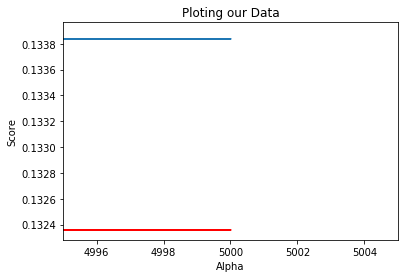

In [15]:
alphaMat = np.array([5000,4000,2000,-1000,-500,-300,-200,-100,-0.1,0,0.01,100,200 ,300,500,700,1000,2000,4000,5000])
method = Ridge 
plotingData(alphaMat,X_train,y_train,X_test, y_test,method)

## Lasso regression

In [16]:
from sklearn.linear_model import Lasso

linlasso = Lasso(alpha=0.5, max_iter = 10000).fit(X_train, y_train)

print('Test with lasso')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Test with lasso
lasso regression linear model intercept: 4.640715599888883
lasso regression linear model coeff:
[ 0.          0.         -0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.03501456 -0.         -0.         -0.05133807
  0.         -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[ -7.64423434e+02  -1.90726596e+02  -4.75675674e+01   1.04650100e-02
   0.00000000e+00   0.00000000e+00]
alpha
[-2.  -1.  -0.5  0.5  1.   2. ]


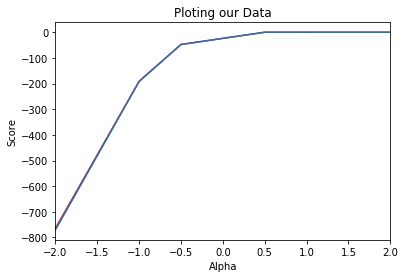

In [17]:
alphaMat = np.array([-2,-1,-0.5,0.5 ,1, 2])
method = Lasso 
plotingData(alphaMat,X_train,y_train,X_test, y_test,method)

## confusion matrix

[[48083    49  1252   248    84   320    29   298   255   751]
 [  169 11320   772   111    52   125    22   154   239   632]
 [ 1693   449 36435  3178   659  1274   352   717  2629  4026]
 [  884   134  5678 28124   597   601   709   356  2129  1664]
 [  650    85  1454   962 39416   316   213  1776   324   937]
 [  570    46  1241   203    81 47798    56   189   396   427]
 [  146    13   532  1232   204   102  5495   136    93   116]
 [  646    36   395   107   555   251    55 44088   200   686]
 [  258   122  1660   797   120   273    35   184 43006   808]
 [ 1543   411  5867  1331   603   652   138   913  1249 39358]]


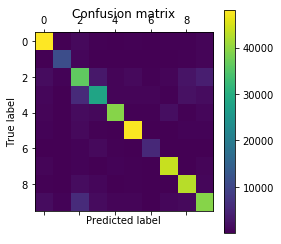

In [18]:
#confusion matrix 
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Precision and Recall Score

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_test_new = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_score =  label_binarize(y_pred, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y_test_new.shape[1]
precision = dict()
recall = dict()
average_precision = dict()
print(n_classes)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_new[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test_new[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_new.ravel(),y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_new, y_score,average="micro")


10


## Report of Precision and Recall

In [20]:
%matplotlib notebook
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.94      0.91     51369
          1       0.89      0.83      0.86     13596
          2       0.66      0.71      0.68     51412
          3       0.77      0.69      0.73     40876
          4       0.93      0.85      0.89     46133
          5       0.92      0.94      0.93     51007
          6       0.77      0.68      0.72      8069
          7       0.90      0.94      0.92     47019
          8       0.85      0.91      0.88     47263
          9       0.80      0.76      0.78     52065

avg / total       0.84      0.84      0.84    408809



## Precision-recall curves

<IPython.core.display.Javascript object>


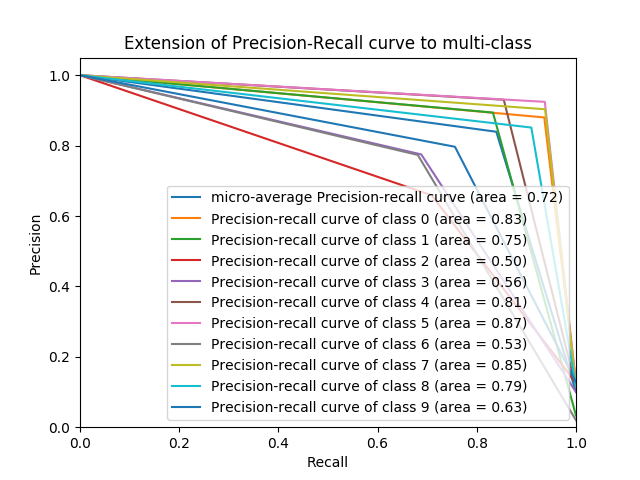

In [22]:
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

## plot Precision Recall for specific class

<IPython.core.display.Javascript object>


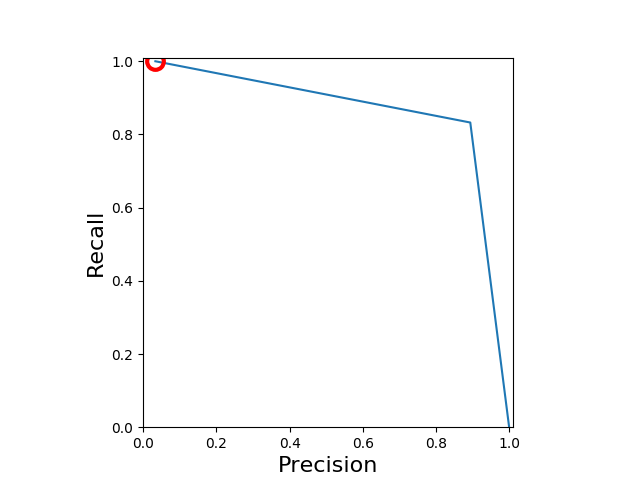

In [23]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_new[:,1], y_score[:,1])
# index of the closest threshold value to zero 
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

## ROC curve for a specific class

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_new[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<IPython.core.display.Javascript object>


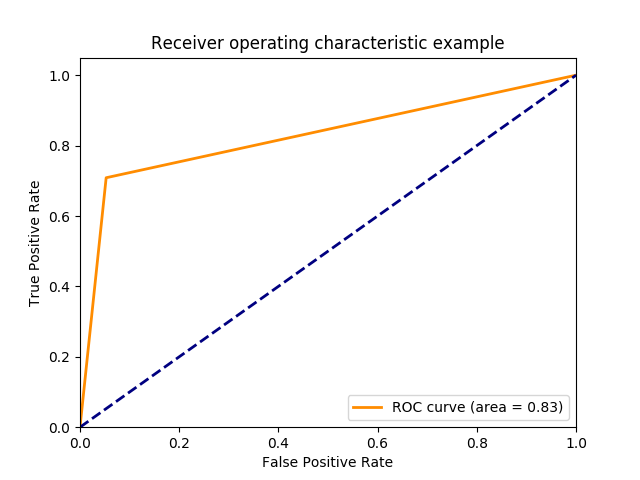

In [25]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()





[ 0.          0.16685944  0.23961041  0.63581853  0.6742765   0.67769028
  0.92573342  0.92595347  0.926219    0.92703475  0.92781859  1.        ]
[ 0.          0.99828045  1.07126294  1.46873197  1.50731233  1.51073697
  1.75956949  1.76028189  1.76114152  1.76378242  1.76632001  2.        ]
[ 0.          1.04497607  1.13831793  1.64666582  1.69600865  1.70038864
  2.01863604  2.06264343  2.11574559  2.27888296  2.43563845  3.        ]
[ 0.          1.14887191  1.28751252  2.04256131  2.11585018  2.12235578
  2.59504844  2.73538538  2.78966109  2.95640375  3.11662352  4.        ]
[ 0.          1.36747183  1.60142233  2.87553712  2.99920916  3.00572235
  3.47896647  3.61964737  3.67433811  3.84235583  4.00380076  5.        ]
[ 0.          1.49446992  1.78379177  3.3594638   3.51240652  3.52151797
  4.18354975  4.44198001  4.63875476  4.8071659   4.96898886  6.        ]
[ 0.          1.9703441   2.46714783  4.04519148  4.19836441  4.20749629
  4.87101281  5.13036912  5.32826131  5.50010

<IPython.core.display.Javascript object>


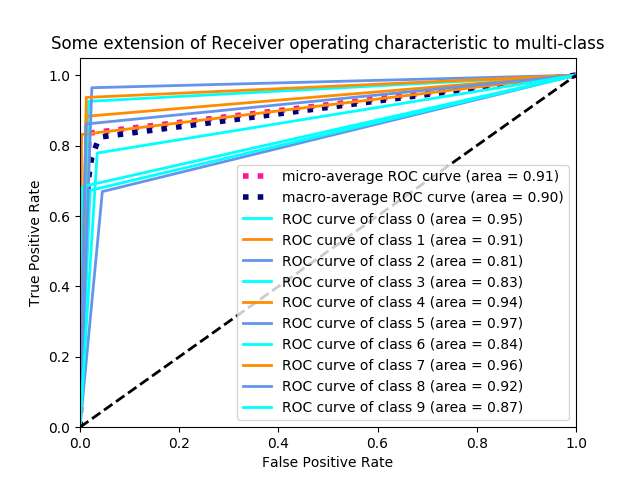

In [18]:
lw = 2
def cycle(iterable):
    # cycle('ABCD') --> A B C D A B C D A B C D ...
    saved = []
    for element in iterable:
        yield element
        saved.append(element)
    while saved:
        for element in saved:
              yield element

# Compute macro-average ROC curve and ROC area
from scipy import interp
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#print(all_fpr)
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    print(mean_tpr)
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()